## Parse EDP and .txt with annotations to a CSV file 

In [5]:
#@title
import os
import numpy as np
import pandas as pd
import urllib.request
from datetime import datetime
!pip install mne
import mne

def to_timestamp(x: str, acq_time: datetime):
    date = datetime.strptime(x, '%H:%M:%S')
    date = datetime(acq_time.year, acq_time.month, acq_time.day, date.hour, date.minute, date.second)
    if date.hour < 12:
        date = datetime(date.year, date.month, date.day + 1, date.hour, date.minute, date.second)
    return (date.day - acq_time.day) * 24 * 3600 + (date.hour - acq_time.hour) * 3600 + (
                date.minute - acq_time.minute) * 60 + date.second - acq_time.second


def subsample(data: np.ndarray, fs: int, fs_new: int, axis=0):
    assert fs % fs_new == 0
    factor = int(fs / fs_new)
    if data.shape[axis] % factor != 0:
        print('Subsampling led to loss of %i samples, in an online setting consider using a BlockBuffer with a '
              'buffer size of a multiple of %i samples.' % (data.shape[axis] % factor, factor))
    idx_mask = np.arange(data.shape[axis], step=factor)
    return data.take(idx_mask, axis)


def read_annotation_file(path_filename: str, acq_time: datetime):
    df_annotations_data = pd.read_csv(path_filename, sep='\t', skiprows=20)
    df_annotations_data = df_annotations_data.loc[df_annotations_data["Event"].str.startswith("SLEEP")]
    df_annotations_data = df_annotations_data.rename(columns={"Time [hh:mm:ss]": "onset", "Duration[s]": "duration"})
    df_annotations_data["timestamp"] = df_annotations_data.onset.apply(lambda x: to_timestamp(x, acq_time))

    return df_annotations_data


def merge_data_file_and_annotations(data, df_annotations, annotation_desc_2_event_id, fs_new):
    raw_data = data.get_data()
    fs = int(data.info["sfreq"])
    labels = np.zeros(raw_data.shape[1])
    for i in range(df_annotations.shape[0] - 1):
        row_start = df_annotations.iloc[i]
        row_end = df_annotations.iloc[i + 1]
        start_pos = row_start.timestamp * fs
        end_pos = row_end.timestamp * fs
        if start_pos < labels.shape[0]:
            labels[start_pos:end_pos] = annotation_desc_2_event_id[row_start.Event]
    labels = labels[:raw_data.shape[-1]]
    df_all_night = pd.DataFrame(raw_data.T, columns=data.info.ch_names)
    df_all_night["times"] = data.times
    df_all_night["sleepstage"] = labels

    df_all_night = df_all_night[df_all_night.sleepstage != 0]
    df = pd.DataFrame(data=subsample(df_all_night.to_numpy(), fs, fs_new), columns=df_all_night.columns)
    return df


In [31]:
subject_name = 'n2'

map_name_sleep_id = {'SLEEP-S0': 1, 'SLEEP-REM': 2, 'SLEEP-S1': 3,
                     'SLEEP-S2': 4, 'SLEEP-S3': 5, 'SLEEP-S4': 5}
              
data_filename = f'{subject_name}.edf'
filename_annotations = f'{subject_name}_annotations.csv'
url_data = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.edf?download'
url_annotations = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.txt?download'

print(f'Downloading data file: {url_data}')
urllib.request.urlretrieve(url_data, data_filename)

print(f'Downloading annotations data file: {url_annotations}')
urllib.request.urlretrieve(url_annotations, filename_annotations)


print(f'Loading File: {data_filename}')
data_polysomnography = mne.io.read_raw_edf(data_filename)

print(f'Loading Annotations file: {filename_annotations}')
df_annotations_polysomnography = read_annotation_file(filename_annotations, data_polysomnography.info["meas_date"])

print("\n\n Example Annotations file: \n")
df_annotations_polysomnography.head(4)

Loading File: n2.edf
Extracting EDF parameters from /content/n2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Loading Annotations file: n2_annotations.csv


 Example Annotations file: 



<ipython-input-31-a00e3277c014>:19: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  data_polysomnography = mne.io.read_raw_edf(data_filename)


,Sleep Stage,onset,Event,duration,Location,timestamp
0,W,22:19:06,SLEEP-S0,30,ROC-LOC,11220
1,W,22:19:36,SLEEP-S0,30,ROC-LOC,11250
2,W,22:20:06,SLEEP-S0,30,ROC-LOC,11280
3,W,22:20:36,SLEEP-S0,30,ROC-LOC,11310


## Downsample data and store data into a csv format

In [27]:
# New frequency
fs_new = 64
new_filename = f'{subject_name}_data_and_annotations.csv'
print(f'Merge files annotation and polysomnography data. Downsampling data from {data_polysomnography.info["sfreq"]} to {fs_new} Hz')
df_data = merge_data_file_and_annotations(data_polysomnography, df_annotations_polysomnography, map_name_sleep_id, fs_new)
df_data.to_csv(new_filename)

print("Data Merged")
df_data.head(4)

Merge files annotation and polysomnography data. Downsampling data from 512.0 to 64 Hz
Data Merged


,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,SAO2,HR,PLETH,STAT,MIC,times,sleepstage
0,0.000044,0.000053,0.000056,-0.000022,-0.000059,-1.205506e-05,8.392846e-07,0.000005,1.007326e-06,-0.000023,94.018463,88.068971,-0.050029,0.0,-0.000005,11220.000000,1.0
1,0.000044,0.000052,0.000051,-0.000030,-0.000040,-6.042789e-06,-2.548373e-06,-0.000085,9.157509e-07,0.000024,94.018463,88.068971,-0.057674,0.0,0.000002,11220.015625,1.0
2,0.000042,0.000056,0.000053,-0.000032,-0.000077,-7.996014e-06,-5.447720e-06,-0.000015,3.052503e-07,0.000012,94.018463,88.068971,-0.061092,0.0,0.000002,11220.031250,1.0
3,0.000045,0.000064,0.000058,-0.000038,-0.000059,2.441531e-07,1.571751e-06,-0.000060,1.770452e-06,-0.000006,94.018463,88.068971,-0.058833,0.0,0.000002,11220.046875,1.0


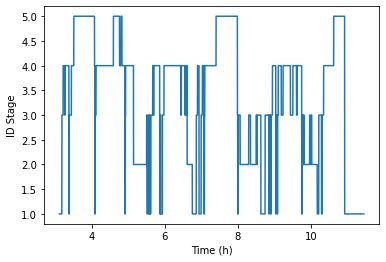

In [35]:
import matplotlib.pyplot as plt
_ = plt.plot(df_data.times/3600, df_data.sleepstage)
_ = plt.xlabel("Time (h)")
_ = plt.ylabel("ID Stage")

## Load CSV

In [26]:
df = pd.read_csv(new_filename)
df.head(4)

,Unnamed: 0,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,SAO2,HR,PLETH,STAT,MIC,times,sleepstage
0,0,0.000044,0.000053,0.000056,-0.000022,-0.000059,-1.205506e-05,8.392846e-07,0.000005,1.007326e-06,-0.000023,94.018463,88.068971,-0.050029,0.0,-0.000005,11220.000000,1.0
1,1,0.000044,0.000052,0.000051,-0.000030,-0.000040,-6.042789e-06,-2.548373e-06,-0.000085,9.157509e-07,0.000024,94.018463,88.068971,-0.057674,0.0,0.000002,11220.015625,1.0
2,2,0.000042,0.000056,0.000053,-0.000032,-0.000077,-7.996014e-06,-5.447720e-06,-0.000015,3.052503e-07,0.000012,94.018463,88.068971,-0.061092,0.0,0.000002,11220.031250,1.0
3,3,0.000045,0.000064,0.000058,-0.000038,-0.000059,2.441531e-07,1.571751e-06,-0.000060,1.770452e-06,-0.000006,94.018463,88.068971,-0.058833,0.0,0.000002,11220.046875,1.0
